#### Dados pandas

In [1]:
# Em seguida iremos importar diversas bibliotecas que serão utilizadas:

# Pacote para trabalhar com JSON
import json

# Pacote para realizar requisições HTTP
import requests

# Pacote para exploração e análise de dados
import pandas as pd

# Pacote com métodos numéricos e representações matriciais
import numpy as np

# Pacote para construção de modelo baseado na técnica Gradient Boosting
import xgboost as xgb

# Pacotes do scikit-learn para pré-processamento de dados
# "SimpleImputer" é uma transformação para preencher valores faltantes em conjuntos de dados
from sklearn.impute import SimpleImputer

# Pacotes do scikit-learn para treinamento de modelos e construção de pipelines
# Método para separação de conjunto de dados em amostras de treino e teste
from sklearn.model_selection import train_test_split
# Método para criação de modelos baseados em árvores de decisão

from sklearn.pipeline import Pipeline

# Pacotes do scikit-learn para avaliação de modelos
# Métodos para validação cruzada do modelo criado
from sklearn.model_selection import KFold, cross_validate

In [2]:
df_data_1 = pd.read_csv("../data_asset/dataset_desafio_2.csv")

In [3]:
# Definição das colunas que serão features (entradas) da Pipeline
features = [
    "MATRICULA", "NOME", 'REPROVACOES_DE', 'REPROVACOES_EM', "REPROVACOES_MF", "REPROVACOES_GO",
    "NOTA_DE", "NOTA_EM", "NOTA_MF", "NOTA_GO",
    "INGLES", "H_AULA_PRES", "TAREFAS_ONLINE", "FALTAS", 
]

X = df_data_1[features]
Y = df_data_1["PERFIL"].values.ravel()

###Trata os dados

**** Proporcionalidade de atividades

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

class PrepareData(BaseEstimator, TransformerMixin):

    def __init__(self, drop_colums, proporcional_in_columns, merge_comlumns_to_name):
        self.drop_colums = drop_colums
        self.proporcional_in_columns = proporcional_in_columns
        self.merge_comlumns_to_name = merge_comlumns_to_name

    def fit(self,X,y=None):
        return self

    def proporcional_in_column(self, data):
        d = data.copy()
        for column in self.proporcional_in_columns:
            median = data[column].median()

            numpy_column = data[column]
            numpy_colum = np.array(numpy_column)

            for i in range(len(numpy_colum)):
                numpy_colum[i] = numpy_colum[i] / median

            d[column] = numpy_colum
        return d
    
    def merge_two_comlumns(self, data):
        d = data.copy()
        new_column = list()
        sum_median = data[self.merge_comlumns_to_name[0]].median() + data[self.merge_comlumns_to_name[1]].median()
        
        numpy_column1 = np.array(data[self.merge_comlumns_to_name[0]])
        numpy_column2 = np.array(data[self.merge_comlumns_to_name[1]])
        
        for i in range(0, len(data[self.merge_comlumns_to_name[0]])):
            v = (numpy_column1[i] + numpy_column2[i]) / sum_median
            new_column.append(v)

        d = d.drop([self.merge_comlumns_to_name[0],self.merge_comlumns_to_name[1]], axis=1)
        d[self.merge_comlumns_to_name[2]] = new_column

        return d

    def transform(self,X):
        data = self.proporcional_in_column(X)
        data = self.merge_two_comlumns(data)
        data = self.nan_values(data)
        return data.drop(labels=self.drop_colums,axis='columns')
    
    def nan_values(self,X):
        si = SimpleImputer(
            missing_values=np.nan,  # os valores faltantes são do tipo ``np.nan`` (padrão Pandas)
            strategy='constant',  # a estratégia escolhida é a alteração do valor faltante por uma constante
            fill_value=0,  # a constante que será usada para preenchimento dos valores faltantes é um int64=0.
            verbose=0,
            copy=True
        )
        
        si.fit(X=X)

        # Reconstrução de um novo DataFrame Pandas com o conjunto imputado (df_data_3)
        data = pd.DataFrame.from_records(
            data=si.transform(
                X=X
            ),  # o resultado SimpleImputer.transform(<<pandas dataframe>>) é lista de listas
            columns=X.columns  # as colunas originais devem ser conservadas nessa transformação
        )
        return data

In [7]:
drop_columns = ['NOME',"MATRICULA","FALTAS","INGLES"]
proporcional_in_columns = ["NOTA_DE","NOTA_GO","NOTA_MF","NOTA_EM"]
merge_comlumns_to_name = ["H_AULA_PRES","TAREFAS_ONLINE","ATIVIDADES"]
features_to_model = [
    'REPROVACOES_DE', 'REPROVACOES_EM', "REPROVACOES_MF", "REPROVACOES_GO",
    "NOTA_DE", "NOTA_EM", "NOTA_MF", "NOTA_GO", "ATIVIDADES"
]
prepare_data = PrepareData(drop_columns,proporcional_in_columns,merge_comlumns_to_name)


**** Encodificação de Y e separação de dados

# MODELO

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils import to_categorical

class DenseModel(BaseEstimator, TransformerMixin):

    def __init__(self,input_s, num_classes, batch_size, epochs, activation, prepare_data):
        self.epochs = epochs
        self.batch_size = batch_size
        self.input_s = input_s
        self.activation = activation
        self.num_classes=num_classes
        self.prepare_data=prepare_data

    def fit(self, X, Y):
        X_train, X_val, Y_train, Y_val = train_test_split(X, self.transform_label(Y), test_size=0.2, random_state=337)
        self.model = self.create()
        self.history = self.model.fit(X_train, Y_train,
                            batch_size=self.epochs,
                            epochs=self.batch_size,
                            validation_data=(X_val, Y_val)
                            )
        return self

    def create(self):
        model = Sequential()
        
        model.add(Dense(self.input_s,
                        activation=self.activation,
                        input_shape=(self.input_s,)))
        
        model.add(Dense(self.num_classes,
                        activation=self.activation))
        
        model.add(Dense(self.num_classes,
                        activation='softmax'))

        model.compile(optimizer="adam",
                      loss='categorical_crossentropy',
                      metrics=['accuracy']
                      )
        return model

    def predict(self,X):
        data = self.prepare_data.transform(X.copy())
        return self.reverse_predicitions_to_label(self.model.predict(data))

    def evaluate(self,X_test,Y_test):
        data = self.prepare_data.transform(X_test.copy())
        return self.model.evaluate(data,self.transform_label(Y_test))

    def get_dense_model(self):
        return self.model

    def get_history(self):
        return self.history
    
    def transform_label(self,y):
        le = preprocessing.LabelEncoder()
        le.fit(y)
        self.classes = le.classes_
        y_prepared = to_categorical(le.transform(y), self.num_classes)
        return y_prepared
    
    def get_classes(self):
        return self.classes
    
    def reverse_predicitions_to_label(self,predictions):
        labels = list()
        for prediction in predictions:

            #prediction tem a quantidade target.
            #em particular, são 5: "DIFICULDADE","EXATAS","MUITO BOM"
            for i in range(0, len(prediction)):
                if prediction[i] >= 0.5:
                    labels.append(self.classes[i])
        return labels
        

In [17]:
import tensorflow as tf

In [42]:
#input_s,num_classes, batch_size, epochs, activation, prepare_data
model = DenseModel(9,5,900,2500,tf.keras.layers.ReLU(negative_slope=0.15,max_value=1.0),prepare_data)

In [43]:
#X_train e Y_train serão dividos dentro do modelo para extrair X_val e Y_val, por isso test_size é pequeno aqui
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=337)

In [44]:
# Criação da nossa pipeline para armazenamento no Watson Machine Learning:
my_pipeline = Pipeline(
    steps=[
        ('prepare_data', prepare_data),
        ('model', model),
    ]
)

In [45]:
my_pipeline.fit(X_train, y_train)

Epoch 1/900
6/6 [==============================] - 0s 29ms/step - loss: 1.6782 - accuracy: 0.1976 - val_loss: 1.6708 - val_accuracy: 0.1964
Epoch 2/900
6/6 [==============================] - 0s 8ms/step - loss: 1.6588 - accuracy: 0.2078 - val_loss: 1.6529 - val_accuracy: 0.2092
Epoch 3/900
6/6 [==============================] - 0s 8ms/step - loss: 1.6412 - accuracy: 0.2235 - val_loss: 1.6365 - val_accuracy: 0.2214
Epoch 4/900
6/6 [==============================] - 0s 9ms/step - loss: 1.6248 - accuracy: 0.2340 - val_loss: 1.6209 - val_accuracy: 0.2392
Epoch 5/900
6/6 [==============================] - 0s 10ms/step - loss: 1.6094 - accuracy: 0.2534 - val_loss: 1.6062 - val_accuracy: 0.2531
Epoch 6/900
6/6 [==============================] - 0s 10ms/step - loss: 1.5947 - accuracy: 0.2637 - val_loss: 1.5919 - val_accuracy: 0.2667
Epoch 7/900
6/6 [==============================] - 0s 10ms/step - loss: 1.5803 - accuracy: 0.2728 - val_loss: 1.5773 - val_accuracy: 0.2839
Epoch 8/900
6/6 [======

6/6 [==============================] - 0s 9ms/step - loss: 0.9758 - accuracy: 0.6222 - val_loss: 0.9814 - val_accuracy: 0.6211
Epoch 60/900
6/6 [==============================] - 0s 9ms/step - loss: 0.9720 - accuracy: 0.6222 - val_loss: 0.9776 - val_accuracy: 0.6211
Epoch 61/900
6/6 [==============================] - 0s 9ms/step - loss: 0.9682 - accuracy: 0.6222 - val_loss: 0.9739 - val_accuracy: 0.6211
Epoch 62/900
6/6 [==============================] - 0s 9ms/step - loss: 0.9645 - accuracy: 0.6227 - val_loss: 0.9701 - val_accuracy: 0.6214
Epoch 63/900
6/6 [==============================] - 0s 8ms/step - loss: 0.9608 - accuracy: 0.6234 - val_loss: 0.9664 - val_accuracy: 0.6228
Epoch 64/900
6/6 [==============================] - 0s 10ms/step - loss: 0.9571 - accuracy: 0.6247 - val_loss: 0.9628 - val_accuracy: 0.6247
Epoch 65/900
6/6 [==============================] - 0s 8ms/step - loss: 0.9534 - accuracy: 0.6269 - val_loss: 0.9592 - val_accuracy: 0.6264
Epoch 66/900
6/6 [==============

6/6 [==============================] - 0s 7ms/step - loss: 0.7687 - accuracy: 0.7137 - val_loss: 0.7779 - val_accuracy: 0.7100
Epoch 118/900
6/6 [==============================] - 0s 8ms/step - loss: 0.7656 - accuracy: 0.7147 - val_loss: 0.7751 - val_accuracy: 0.7094
Epoch 119/900
6/6 [==============================] - 0s 8ms/step - loss: 0.7626 - accuracy: 0.7147 - val_loss: 0.7721 - val_accuracy: 0.7119
Epoch 120/900
6/6 [==============================] - 0s 7ms/step - loss: 0.7596 - accuracy: 0.7175 - val_loss: 0.7692 - val_accuracy: 0.7142
Epoch 121/900
6/6 [==============================] - 0s 7ms/step - loss: 0.7566 - accuracy: 0.7219 - val_loss: 0.7663 - val_accuracy: 0.7139
Epoch 122/900
6/6 [==============================] - 0s 8ms/step - loss: 0.7534 - accuracy: 0.7208 - val_loss: 0.7632 - val_accuracy: 0.7147
Epoch 123/900
6/6 [==============================] - 0s 10ms/step - loss: 0.7502 - accuracy: 0.7215 - val_loss: 0.7599 - val_accuracy: 0.7181
Epoch 124/900
6/6 [=======

Epoch 175/900
6/6 [==============================] - 0s 9ms/step - loss: 0.6467 - accuracy: 0.7617 - val_loss: 0.6594 - val_accuracy: 0.7592
Epoch 176/900
6/6 [==============================] - 0s 10ms/step - loss: 0.6455 - accuracy: 0.7671 - val_loss: 0.6584 - val_accuracy: 0.7603
Epoch 177/900
6/6 [==============================] - 0s 9ms/step - loss: 0.6444 - accuracy: 0.7655 - val_loss: 0.6573 - val_accuracy: 0.7575
Epoch 178/900
6/6 [==============================] - 0s 10ms/step - loss: 0.6436 - accuracy: 0.7665 - val_loss: 0.6561 - val_accuracy: 0.7594
Epoch 179/900
6/6 [==============================] - 0s 9ms/step - loss: 0.6420 - accuracy: 0.7647 - val_loss: 0.6552 - val_accuracy: 0.7594
Epoch 180/900
6/6 [==============================] - 0s 9ms/step - loss: 0.6410 - accuracy: 0.7672 - val_loss: 0.6539 - val_accuracy: 0.7608
Epoch 181/900
6/6 [==============================] - 0s 10ms/step - loss: 0.6399 - accuracy: 0.7656 - val_loss: 0.6530 - val_accuracy: 0.7589
Epoch 182/

Epoch 233/900
6/6 [==============================] - 0s 11ms/step - loss: 0.5999 - accuracy: 0.7794 - val_loss: 0.6154 - val_accuracy: 0.7722
Epoch 234/900
6/6 [==============================] - 0s 9ms/step - loss: 0.5994 - accuracy: 0.7789 - val_loss: 0.6148 - val_accuracy: 0.7742
Epoch 235/900
6/6 [==============================] - 0s 8ms/step - loss: 0.5989 - accuracy: 0.7794 - val_loss: 0.6144 - val_accuracy: 0.7728
Epoch 236/900
6/6 [==============================] - 0s 8ms/step - loss: 0.5984 - accuracy: 0.7789 - val_loss: 0.6139 - val_accuracy: 0.7742
Epoch 237/900
6/6 [==============================] - 0s 9ms/step - loss: 0.5978 - accuracy: 0.7794 - val_loss: 0.6134 - val_accuracy: 0.7731
Epoch 238/900
6/6 [==============================] - 0s 7ms/step - loss: 0.5973 - accuracy: 0.7777 - val_loss: 0.6129 - val_accuracy: 0.7736
Epoch 239/900
6/6 [==============================] - 0s 7ms/step - loss: 0.5968 - accuracy: 0.7795 - val_loss: 0.6124 - val_accuracy: 0.7750
Epoch 240/90

Epoch 291/900
6/6 [==============================] - 0s 13ms/step - loss: 0.5771 - accuracy: 0.7827 - val_loss: 0.5936 - val_accuracy: 0.7742
Epoch 292/900
6/6 [==============================] - 0s 12ms/step - loss: 0.5767 - accuracy: 0.7849 - val_loss: 0.5932 - val_accuracy: 0.7753
Epoch 293/900
6/6 [==============================] - 0s 8ms/step - loss: 0.5766 - accuracy: 0.7831 - val_loss: 0.5931 - val_accuracy: 0.7736
Epoch 294/900
6/6 [==============================] - 0s 8ms/step - loss: 0.5760 - accuracy: 0.7846 - val_loss: 0.5926 - val_accuracy: 0.7750
Epoch 295/900
6/6 [==============================] - 0s 9ms/step - loss: 0.5755 - accuracy: 0.7835 - val_loss: 0.5925 - val_accuracy: 0.7742
Epoch 296/900
6/6 [==============================] - 0s 11ms/step - loss: 0.5754 - accuracy: 0.7843 - val_loss: 0.5921 - val_accuracy: 0.7769
Epoch 297/900
6/6 [==============================] - 0s 9ms/step - loss: 0.5750 - accuracy: 0.7834 - val_loss: 0.5918 - val_accuracy: 0.7725
Epoch 298/

Epoch 349/900
6/6 [==============================] - 0s 11ms/step - loss: 0.5627 - accuracy: 0.7869 - val_loss: 0.5794 - val_accuracy: 0.7778
Epoch 350/900
6/6 [==============================] - 0s 12ms/step - loss: 0.5624 - accuracy: 0.7878 - val_loss: 0.5793 - val_accuracy: 0.7764
Epoch 351/900
6/6 [==============================] - 0s 12ms/step - loss: 0.5622 - accuracy: 0.7866 - val_loss: 0.5791 - val_accuracy: 0.7775
Epoch 352/900
6/6 [==============================] - 0s 10ms/step - loss: 0.5621 - accuracy: 0.7876 - val_loss: 0.5789 - val_accuracy: 0.7778
Epoch 353/900
6/6 [==============================] - 0s 10ms/step - loss: 0.5618 - accuracy: 0.7872 - val_loss: 0.5788 - val_accuracy: 0.7764
Epoch 354/900
6/6 [==============================] - 0s 8ms/step - loss: 0.5616 - accuracy: 0.7864 - val_loss: 0.5784 - val_accuracy: 0.7775
Epoch 355/900
6/6 [==============================] - 0s 9ms/step - loss: 0.5616 - accuracy: 0.7876 - val_loss: 0.5783 - val_accuracy: 0.7767
Epoch 35

Epoch 407/900
6/6 [==============================] - 0s 10ms/step - loss: 0.5516 - accuracy: 0.7903 - val_loss: 0.5682 - val_accuracy: 0.7783
Epoch 408/900
6/6 [==============================] - 0s 10ms/step - loss: 0.5515 - accuracy: 0.7884 - val_loss: 0.5680 - val_accuracy: 0.7767
Epoch 409/900
6/6 [==============================] - 0s 10ms/step - loss: 0.5512 - accuracy: 0.7894 - val_loss: 0.5677 - val_accuracy: 0.7794
Epoch 410/900
6/6 [==============================] - 0s 10ms/step - loss: 0.5510 - accuracy: 0.7902 - val_loss: 0.5675 - val_accuracy: 0.7778
Epoch 411/900
6/6 [==============================] - 0s 11ms/step - loss: 0.5509 - accuracy: 0.7883 - val_loss: 0.5673 - val_accuracy: 0.7786
Epoch 412/900
6/6 [==============================] - 0s 10ms/step - loss: 0.5506 - accuracy: 0.7901 - val_loss: 0.5671 - val_accuracy: 0.7786
Epoch 413/900
6/6 [==============================] - 0s 11ms/step - loss: 0.5505 - accuracy: 0.7891 - val_loss: 0.5669 - val_accuracy: 0.7803
Epoch 

Epoch 465/900
6/6 [==============================] - 0s 13ms/step - loss: 0.5392 - accuracy: 0.7919 - val_loss: 0.5534 - val_accuracy: 0.7814
Epoch 466/900
6/6 [==============================] - 0s 11ms/step - loss: 0.5389 - accuracy: 0.7924 - val_loss: 0.5532 - val_accuracy: 0.7786
Epoch 467/900
6/6 [==============================] - 0s 12ms/step - loss: 0.5387 - accuracy: 0.7906 - val_loss: 0.5529 - val_accuracy: 0.7789
Epoch 468/900
6/6 [==============================] - 0s 10ms/step - loss: 0.5384 - accuracy: 0.7916 - val_loss: 0.5525 - val_accuracy: 0.7803
Epoch 469/900
6/6 [==============================] - 0s 9ms/step - loss: 0.5381 - accuracy: 0.7928 - val_loss: 0.5523 - val_accuracy: 0.7778
Epoch 470/900
6/6 [==============================] - 0s 8ms/step - loss: 0.5378 - accuracy: 0.7906 - val_loss: 0.5519 - val_accuracy: 0.7783
Epoch 471/900
6/6 [==============================] - 0s 11ms/step - loss: 0.5375 - accuracy: 0.7919 - val_loss: 0.5515 - val_accuracy: 0.7783
Epoch 47

Epoch 523/900
6/6 [==============================] - 0s 8ms/step - loss: 0.5232 - accuracy: 0.7916 - val_loss: 0.5352 - val_accuracy: 0.7808
Epoch 524/900
6/6 [==============================] - 0s 9ms/step - loss: 0.5229 - accuracy: 0.7933 - val_loss: 0.5351 - val_accuracy: 0.7800
Epoch 525/900
6/6 [==============================] - 0s 8ms/step - loss: 0.5226 - accuracy: 0.7929 - val_loss: 0.5348 - val_accuracy: 0.7792
Epoch 526/900
6/6 [==============================] - 0s 8ms/step - loss: 0.5225 - accuracy: 0.7922 - val_loss: 0.5347 - val_accuracy: 0.7811
Epoch 527/900
6/6 [==============================] - 0s 7ms/step - loss: 0.5222 - accuracy: 0.7932 - val_loss: 0.5342 - val_accuracy: 0.7811
Epoch 528/900
6/6 [==============================] - 0s 7ms/step - loss: 0.5220 - accuracy: 0.7926 - val_loss: 0.5341 - val_accuracy: 0.7797
Epoch 529/900
6/6 [==============================] - 0s 7ms/step - loss: 0.5218 - accuracy: 0.7935 - val_loss: 0.5338 - val_accuracy: 0.7811
Epoch 530/900

6/6 [==============================] - 0s 7ms/step - loss: 0.5109 - accuracy: 0.7977 - val_loss: 0.5228 - val_accuracy: 0.7908
Epoch 582/900
6/6 [==============================] - 0s 7ms/step - loss: 0.5108 - accuracy: 0.7984 - val_loss: 0.5227 - val_accuracy: 0.7919
Epoch 583/900
6/6 [==============================] - 0s 8ms/step - loss: 0.5108 - accuracy: 0.7983 - val_loss: 0.5227 - val_accuracy: 0.7914
Epoch 584/900
6/6 [==============================] - 0s 7ms/step - loss: 0.5105 - accuracy: 0.7994 - val_loss: 0.5224 - val_accuracy: 0.7914
Epoch 585/900
6/6 [==============================] - 0s 7ms/step - loss: 0.5104 - accuracy: 0.7972 - val_loss: 0.5223 - val_accuracy: 0.7925
Epoch 586/900
6/6 [==============================] - 0s 7ms/step - loss: 0.5102 - accuracy: 0.7998 - val_loss: 0.5222 - val_accuracy: 0.7925
Epoch 587/900
6/6 [==============================] - 0s 7ms/step - loss: 0.5100 - accuracy: 0.7986 - val_loss: 0.5219 - val_accuracy: 0.7931
Epoch 588/900
6/6 [========

6/6 [==============================] - 0s 9ms/step - loss: 0.5028 - accuracy: 0.8065 - val_loss: 0.5156 - val_accuracy: 0.8008
Epoch 640/900
6/6 [==============================] - 0s 7ms/step - loss: 0.5024 - accuracy: 0.8051 - val_loss: 0.5154 - val_accuracy: 0.8008
Epoch 641/900
6/6 [==============================] - 0s 9ms/step - loss: 0.5022 - accuracy: 0.8066 - val_loss: 0.5153 - val_accuracy: 0.8014
Epoch 642/900
6/6 [==============================] - 0s 10ms/step - loss: 0.5020 - accuracy: 0.8061 - val_loss: 0.5153 - val_accuracy: 0.7994
Epoch 643/900
6/6 [==============================] - 0s 9ms/step - loss: 0.5020 - accuracy: 0.8048 - val_loss: 0.5151 - val_accuracy: 0.8014
Epoch 644/900
6/6 [==============================] - 0s 10ms/step - loss: 0.5020 - accuracy: 0.8070 - val_loss: 0.5150 - val_accuracy: 0.8003
Epoch 645/900
6/6 [==============================] - 0s 8ms/step - loss: 0.5017 - accuracy: 0.8047 - val_loss: 0.5153 - val_accuracy: 0.7992
Epoch 646/900
6/6 [======

6/6 [==============================] - 0s 7ms/step - loss: 0.4967 - accuracy: 0.8093 - val_loss: 0.5103 - val_accuracy: 0.8033
Epoch 698/900
6/6 [==============================] - 0s 8ms/step - loss: 0.4967 - accuracy: 0.8081 - val_loss: 0.5101 - val_accuracy: 0.8031
Epoch 699/900
6/6 [==============================] - 0s 7ms/step - loss: 0.4965 - accuracy: 0.8096 - val_loss: 0.5098 - val_accuracy: 0.8053
Epoch 700/900
6/6 [==============================] - 0s 8ms/step - loss: 0.4964 - accuracy: 0.8096 - val_loss: 0.5098 - val_accuracy: 0.8039
Epoch 701/900
6/6 [==============================] - 0s 7ms/step - loss: 0.4965 - accuracy: 0.8078 - val_loss: 0.5097 - val_accuracy: 0.8019
Epoch 702/900
6/6 [==============================] - 0s 7ms/step - loss: 0.4962 - accuracy: 0.8099 - val_loss: 0.5096 - val_accuracy: 0.8047
Epoch 703/900
6/6 [==============================] - 0s 8ms/step - loss: 0.4965 - accuracy: 0.8080 - val_loss: 0.5097 - val_accuracy: 0.8033
Epoch 704/900
6/6 [========

6/6 [==============================] - 0s 8ms/step - loss: 0.4922 - accuracy: 0.8096 - val_loss: 0.5059 - val_accuracy: 0.8031
Epoch 756/900
6/6 [==============================] - 0s 8ms/step - loss: 0.4925 - accuracy: 0.8099 - val_loss: 0.5057 - val_accuracy: 0.8036
Epoch 757/900
6/6 [==============================] - 0s 7ms/step - loss: 0.4921 - accuracy: 0.8097 - val_loss: 0.5058 - val_accuracy: 0.8033
Epoch 758/900
6/6 [==============================] - 0s 8ms/step - loss: 0.4924 - accuracy: 0.8087 - val_loss: 0.5057 - val_accuracy: 0.8036
Epoch 759/900
6/6 [==============================] - 0s 8ms/step - loss: 0.4919 - accuracy: 0.8099 - val_loss: 0.5057 - val_accuracy: 0.8044
Epoch 760/900
6/6 [==============================] - 0s 7ms/step - loss: 0.4922 - accuracy: 0.8103 - val_loss: 0.5055 - val_accuracy: 0.8050
Epoch 761/900
6/6 [==============================] - 0s 8ms/step - loss: 0.4921 - accuracy: 0.8090 - val_loss: 0.5057 - val_accuracy: 0.8031
Epoch 762/900
6/6 [========

6/6 [==============================] - 0s 8ms/step - loss: 0.4897 - accuracy: 0.8081 - val_loss: 0.5023 - val_accuracy: 0.8047
Epoch 814/900
6/6 [==============================] - 0s 9ms/step - loss: 0.4894 - accuracy: 0.8104 - val_loss: 0.5025 - val_accuracy: 0.8050
Epoch 815/900
6/6 [==============================] - 0s 10ms/step - loss: 0.4891 - accuracy: 0.8098 - val_loss: 0.5025 - val_accuracy: 0.8017
Epoch 816/900
6/6 [==============================] - 0s 8ms/step - loss: 0.4890 - accuracy: 0.8108 - val_loss: 0.5021 - val_accuracy: 0.8056
Epoch 817/900
6/6 [==============================] - 0s 8ms/step - loss: 0.4888 - accuracy: 0.8099 - val_loss: 0.5022 - val_accuracy: 0.8047
Epoch 818/900
6/6 [==============================] - 0s 8ms/step - loss: 0.4890 - accuracy: 0.8100 - val_loss: 0.5020 - val_accuracy: 0.8064
Epoch 819/900
6/6 [==============================] - 0s 7ms/step - loss: 0.4888 - accuracy: 0.8102 - val_loss: 0.5020 - val_accuracy: 0.8061
Epoch 820/900
6/6 [=======

6/6 [==============================] - 0s 7ms/step - loss: 0.4865 - accuracy: 0.8103 - val_loss: 0.4992 - val_accuracy: 0.8047
Epoch 872/900
6/6 [==============================] - 0s 7ms/step - loss: 0.4861 - accuracy: 0.8112 - val_loss: 0.4988 - val_accuracy: 0.8056
Epoch 873/900
6/6 [==============================] - 0s 7ms/step - loss: 0.4862 - accuracy: 0.8112 - val_loss: 0.4989 - val_accuracy: 0.8061
Epoch 874/900
6/6 [==============================] - 0s 7ms/step - loss: 0.4861 - accuracy: 0.8099 - val_loss: 0.4990 - val_accuracy: 0.8044
Epoch 875/900
6/6 [==============================] - 0s 7ms/step - loss: 0.4859 - accuracy: 0.8106 - val_loss: 0.4987 - val_accuracy: 0.8064
Epoch 876/900
6/6 [==============================] - 0s 8ms/step - loss: 0.4860 - accuracy: 0.8114 - val_loss: 0.4988 - val_accuracy: 0.8050
Epoch 877/900
6/6 [==============================] - 0s 7ms/step - loss: 0.4859 - accuracy: 0.8093 - val_loss: 0.4986 - val_accuracy: 0.8061
Epoch 878/900
6/6 [========

Pipeline(steps=[('prepare_data',
                 PrepareData(drop_colums=['NOME', 'MATRICULA', 'FALTAS',
                                          'INGLES'],
                             merge_comlumns_to_name=['H_AULA_PRES',
                                                     'TAREFAS_ONLINE',
                                                     'ATIVIDADES'],
                             proporcional_in_columns=['NOTA_DE', 'NOTA_GO',
                                                      'NOTA_MF', 'NOTA_EM'])),
                ('model',
                 DenseModel(activation=<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7fa3c8aa3908>,
                            batch_size=900, epochs=2500, input_s=9,
                            num_classes=5,
                            prepare_data=PrepareData(drop_colums=['NOME',
                                                                  'MATRICULA',
                                                                 

# Respostas do modelo e testes

In [29]:
predictions = model.predict(X_test)

In [30]:
predictions

['DIFICULDADE',
 'DIFICULDADE',
 'DIFICULDADE',
 'EXATAS',
 'EXATAS',
 'EXCELENTE',
 'EXATAS',
 'EXATAS',
 'DIFICULDADE',
 'EXATAS',
 'HUMANAS',
 'EXATAS',
 'EXATAS',
 'EXATAS',
 'EXATAS',
 'EXATAS',
 'EXATAS',
 'EXATAS',
 'EXCELENTE',
 'DIFICULDADE',
 'EXATAS',
 'HUMANAS',
 'EXATAS',
 'DIFICULDADE',
 'DIFICULDADE',
 'HUMANAS',
 'DIFICULDADE',
 'DIFICULDADE',
 'EXATAS',
 'DIFICULDADE',
 'HUMANAS',
 'HUMANAS',
 'EXATAS',
 'EXATAS',
 'HUMANAS',
 'EXATAS',
 'EXATAS',
 'HUMANAS',
 'DIFICULDADE',
 'EXATAS',
 'EXCELENTE',
 'DIFICULDADE',
 'DIFICULDADE',
 'HUMANAS',
 'EXATAS',
 'EXATAS',
 'EXATAS',
 'EXATAS',
 'DIFICULDADE',
 'EXCELENTE',
 'EXATAS',
 'DIFICULDADE',
 'DIFICULDADE',
 'HUMANAS',
 'EXATAS',
 'HUMANAS',
 'DIFICULDADE',
 'DIFICULDADE',
 'EXATAS',
 'EXATAS',
 'DIFICULDADE',
 'HUMANAS',
 'EXATAS',
 'DIFICULDADE',
 'EXATAS',
 'EXATAS',
 'DIFICULDADE',
 'EXATAS',
 'HUMANAS',
 'EXATAS',
 'EXATAS',
 'HUMANAS',
 'EXATAS',
 'HUMANAS',
 'DIFICULDADE',
 'DIFICULDADE',
 'EXATAS',
 'HUMANAS',


In [46]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.5071 - accuracy: 0.8025


[0.5071431398391724, 0.8025000095367432]

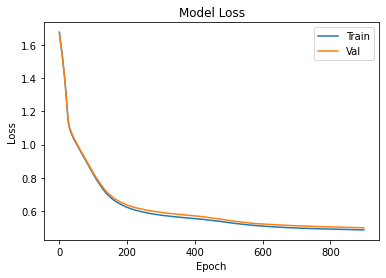

In [47]:
import matplotlib.pyplot as plt
history = model.get_history()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

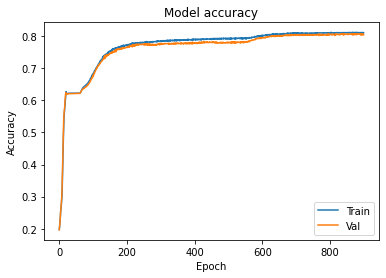

In [48]:
history = model.get_history()

plt.plot(history.history['accuracy'] )
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()